In [2]:
import numpy as np
#%% functions needed for dynamic_rupture.py
class rup_fun:

#%% inplane wave propagation
    def waveinplane(xx,zz,vx,vz,txx,tzz,txz,Lambda,G,dt,rho):
        
        #for velocities we use the old stress variables
        dtxxdxx=np.diff(txx,axis=1)/np.diff(xx,axis=1);dtxxdxx=dtxxdxx[:-1,:];
        dtxzdzz=np.diff(txz,axis=0)/np.diff(zz,axis=0);dtxzdzz=dtxzdzz[:,1:];
        vx[:-1,1:]=vx[:-1,1:]+dt/rho*(dtxxdxx+dtxzdzz);
        
        dtxzdxx=np.diff(txz,axis=1)/np.diff(xx,axis=1);dtxzdxx=dtxzdxx[1:,:];
        dtzzdzz=np.diff(tzz,axis=0)/np.diff(zz,axis=0);dtzzdzz=dtzzdzz[:,:-1];
        vz[1:,:-1]=vz[1:,:-1]+dt/rho*(dtxzdxx+dtzzdzz);
        
        #for stresses we use the newly calculated velocities
        dvxdxx= np.diff(vx,axis=1)/np.diff(xx,axis=1);dvxdxx=dvxdxx[:-1,:];
        dvzdzz=np.diff(vz,axis=0)/np.diff(zz,axis=0);dvzdzz=dvzdzz[:,:-1];
        txx[:-1,:-1]=txx[:-1,:-1]+dt*((Lambda+2*G)*dvxdxx+Lambda*dvzdzz);
        tzz[:-1,:-1]=tzz[:-1,:-1]+dt*(Lambda*dvxdxx+(Lambda+2*G)*dvzdzz);
        
        dvxdzz=np.diff(vx,axis=0)/np.diff(zz,axis=0);dvxdzz=dvxdzz[:,1:];
        dvzdxx=np.diff(vz,axis=1)/np.diff(xx,axis=1);dvzdxx=dvzdxx[1:,:];
        txz[1:,1:]=txz[1:,1:]+dt*G*(dvxdzz+dvzdxx);

        #% impose BC

###      On the horizontal sides (parallel to fault)
        vx[0,:]=0;vx[-1,:]=0;
        vz[0,:]=0;vz[-1,:]=0;
#         txx[0,:]=0;txx[-1,:]=0;
#         tzz[0,:]=0;tzz[-1,:]=0;
#         txz[0,:]=0;txz[-1,:]=0;
        
###      On the vertical sides (perpendicular to fault)
#         vx[:,-1]=0;vx[:,0]=0;
#         vz[:,-1]=0;vz[:,0]=0;
        txx[:,-2]=0;txx[:,1]=0;
        tzz[:,-2]=0;tzz[:,1]=0;
        txz[:,-2]=0;txz[:,1]=0;
    
    
        return [vx,vz,txx,tzz,txz]


#%% optic equations for fringe similation 

    def fringecalculation(txz_abs,tzz_abs,txx_abs):
        ##fringe pattern calculation
        #photoelasticity parameters
        H=0.01; #thichness of plate in m
        F=6000; #(N/m) corresponds to the material fringe constant (Dally)
        phi=0;
        beta=np.pi/4;
        
        #calculate principal stresses
        s1 = ((tzz_abs+txx_abs)/2)+(((tzz_abs-txx_abs)/2)**2 + txz_abs**2)**0.5; 
        s2 = ((tzz_abs+txx_abs)/2)-(((tzz_abs-txx_abs)/2)**2 + txz_abs**2)**0.5;
        
        # calculation of isocline alpha and isochromatic sigma
        Teta=1/2.*np.arctan2(2*txz_abs,(tzz_abs-txx_abs)); 
        alpha=2*np.pi*H*(s1-s2)/F;
        Iv=1; #amplitude
        #Equation from wand and patterson(fuzzy sets
        Im=0;
        I=Im+Iv*(np.sin((beta-phi))**2*np.cos(alpha)-np.sin((Teta-phi)**2)*np.cos(beta-phi)*np.sin(alpha));
        return I


#%% slip weakening law

    def SW_law(u_interface,rup,txz,prestress,nzs,tau_f,tau_0,tau_p,dt,vx,Dc,loading_rate):
        ## or spontaneous rupture
        u_interface=u_interface+2*vx[nzs,:]*dt; #factor 2 to take into account vx in opposite direction
        ##option to lock interface when rup pass to 0
#         tol=0.01; #tolerance to lock interface when velocity goes to 0
#         rup[np.logical_and(rup==1,(vx[nzs,:]<=0+tol))]=0;    
        
        rup[np.logical_and(rup==0,(np.abs(txz[nzs,:]+prestress)>tau_p))]=1;
#         rup[:2]=0;rup[-3:]=0; # if we want to fix the edges
        #posrup[it,:]=diff(rup,1,2);
        txz[nzs,rup==1]=tau_p-(tau_p-tau_f)/Dc*u_interface[rup==1]-prestress[rup==1];
        txz[nzs,txz[nzs,:]<(tau_f-tau_0)]=tau_f-tau_0;
    #    u_interface_old=u_interface_new;
        
        #to increase the loading 
        tau_p=tau_p-loading_rate*dt;
        tau_f=tau_f-loading_rate*dt;
        
        return [u_interface,rup,txz,tau_f,tau_p,dt]

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.interactive(True)
from IPython import display
from matplotlib import animation, rc
import matplotlib.ticker as ticker
import time
from tqdm import tqdm

#%% simulation parameters:=====================================================
scaling_factor=1
tmax=0.4e-3*scaling_factor;
nx=600; #nb of elements
nz=600
FL=0.3*scaling_factor;
sg_pos=np.array([7e-2,12e-2,17e-2,22e-2])
sg_pos_z=0.15+2e-3#+FL/2
size_patch=1/2*4.1e-2*scaling_factor; # size half patch in m
center=0.084#+FL/3;
Dc=12e-6*scaling_factor;
tau_0=1.5e6;tau_p=2.23e6;tau_f=0.9e6;
prestress_factor=1.00
loading_rate=1e6;

#%% define constants:==========================================================

G=np.float64(0.96e9); #shear modulus
nu=np.float64(0.35); #poisson ratio
rho=np.float64(1200); #density
E=2*G*(1+nu);
vs=(G/rho)**0.5;
vp=((2*G*(1-nu))/(rho*(1-2*nu)))**0.5;
Lambda=(2*G*nu)/(1-2*nu);

# non-dimensional indicators (see madriaga's book): ===========================

k=(tau_0-tau_f)**2*size_patch*4/(G*(tau_p-tau_f)*Dc)
Lc_est=8*(Lambda+G)*G*0.5*(tau_p-tau_f)*Dc/(np.pi*(Lambda+2*G)*(tau_0-tau_f)**2)
S=(tau_p-tau_0)/(tau_0-tau_f)
L_c_check=2*G/(1-nu)*Dc/(np.pi)*(tau_p-tau_f)/(tau_0-tau_f)**2
# L_c_check=4*G*(Lambda+G)/(np.pi*(Lambda+2*G)) * Dc * (tau_p-tau_f)/(tau_0-tau_f)**2
print('k='+str(k));print('S='+str(S));print('Lc_est='+str(Lc_est))
print('L_c_check='+str(L_c_check))

#%% construct the grid=========================================================

x=np.linspace(0,FL,nx);
z=np.linspace(0,FL,nz);
dx=np.abs(x[1]-x[0]);
dz=np.abs(z[1]-z[0]);
[xx,zz]=np.meshgrid(x,z);
## initializes the vectors
vx=xx*0
vz=xx*0
txx=xx*0
tzz=xx*0
txz=xx*0
## refined grid for fringes
x2=np.linspace(0,FL,nx*3);
z2=np.linspace(0,FL,nz*3);
[xx2,zz2]=np.meshgrid(x,z);

#%% create timespace===========================================================

dt=0.4/(vp*np.sqrt(1/dx**2+1/dz**2)); #timestep according to courant stability criterion
t=np.linspace(0,tmax,int(np.round(tmax/dt)));nt=len(t);
# create time map of any parameters (to define) of the simulation
map_sim=np.zeros((nx,nt))
[tt,xt]=np.meshgrid(t,x)
ims = []
#%% Define strain gage position for signal examples============================

sg_idz=np.where(np.logical_and(z>=sg_pos_z-dz/2,z<sg_pos_z+dz/2))
sg_idx=sg_pos*0;
i=0
for pos in sg_pos:
    sg_idx[i]=np.where(np.logical_and(x>=pos-dx/2,x<pos+dx/2))[0][0]
    i=i+1
sg_idx=sg_idx.astype(int)
sg=np.zeros((len(sg_pos),nt))
sg2=np.zeros((len(sg_pos),nt))
sg2bis=np.zeros((len(sg_pos),nt))
sg3=np.zeros((len(sg_pos),nt))
dispnt=np.zeros((len(sg_pos),nt))
exxnt=np.zeros((len(sg_pos),nt))
dispxxnt=sg_idx*0
dispxxnt_up=sg_idx*0
dispxxnt_dn=sg_idx*0
#%%source terms for a pulse====================================================

## amplitude of gaussian pulse for point source
#f0=50/(tmax); 
#t0=3/f0;
#amp=1*np.exp(-f0**2*(t-t0)**2); amp=amp-amp[0];

#%%Spontaneous rupture initiation==============================================

nxs=np.where(np.logical_and(x>=center-dx/2,x<center+dx/2))[0][0]
nb_pt_patch=int(round(size_patch/dx));
#nxs=round(nx/2);
nzs=round(nz/2);
rup=np.zeros([1,nx])[0];#posrup=zeros(nt,nx-1);
prestress=rup*0
prestress[0:nx]=tau_0;prestress[(nxs-nb_pt_patch):(nxs+nb_pt_patch)]=tau_p*prestress_factor;
u_interface=np.zeros([1,nx])[0];
stress_init=xx*0+prestress[0];

#%% Save pictures==============================================================
import os
mymetadata={}
mymetadata['tmax']=str(tmax);
mymetadata['nx']=str(nx);
mymetadata['nz']=str(nz);
mymetadata['FL']=str(FL);
mymetadata['sg_pos']=np.array([7e-2,12e-2,17e-2,22e-2,26e-2])
mymetadata['sg_pos_z']=str(sg_pos_z);
mymetadata['size_patch']=str(size_patch);
mymetadata['center']=str(center);
mymetadata['Dc']=str(Dc);
mymetadata['tau_0']=str(tau_0);
mymetadata['tau_p']=str(tau_p);
mymetadata['tau_f']=str(tau_f);
mymetadata['prestress_factor']=str(prestress_factor);
mymetadata['loading_rate']=str(loading_rate)

k=1.92669172932
S=1.2166666666666666
Lc_est=0.0416839038646
L_c_check=0.0416839038646


<IPython.core.display.Javascript object>


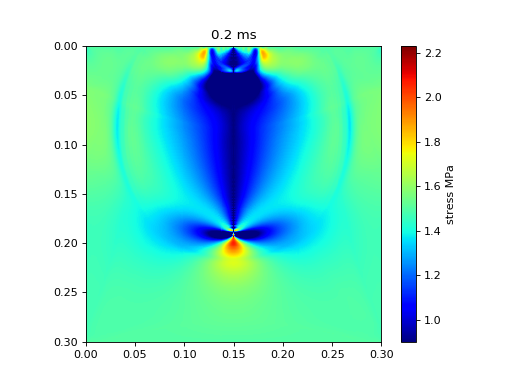

100%|██████████████████████████████████████| 5257/5257 [07:18<00:00, 11.99it/s]


In [46]:
#%% Main time loop=============================================================
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2
%matplotlib notebook

plt.close('all')
f1=plt.figure(1)#,figsize=(7,6))
ax1=f1.add_subplot(111)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_ylim(FL, 0)
ax1.set_aspect('equal')
plt.ion()

import matplotlib as mpl
#from mpl_toolkits.axes_grid1 import make_axes_locatable
norm = mpl.colors.Normalize(vmin=(tau_f-0.2)*10**-6, vmax=tau_p*10**-6)

m = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
#m = plt.cm.ScalarMappable(cmap=plt.cm.gray, norm=norm)
m.set_array([])
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="4.6%", pad=0.04)
cbar=plt.colorbar(m)#, cax=cax)#,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('stress MPa')
ruptips=np.zeros((2,nt))

f1.show()
f1.canvas.draw()

for it in tqdm(range(nt)):
    [vx,vz,txx,tzz,txz]=rup_fun.waveinplane(xx,zz,vx,vz,txx,tzz,txz,Lambda,G,dt,rho);
#
#    % src term for kinematic ruputre
#    vx_new[np.round(len(x)/2),np.round(len(z)/2)]=vx_new[np.round(len(x)/2),np.round(len(z)/2)]+amp[it];
    
#    ## or spontaneous rupture=================================================
    [u_interface,rup,txz,tau_f,tau_p,dt]=rup_fun.SW_law(u_interface,rup,txz,prestress,nzs,tau_f,tau_0,tau_p,dt,vx,Dc,loading_rate)


#     %% plots
#%% absolute stresses corrected for plots======================================
    txz_abs=txz+stress_init+(it)*loading_rate*dt;
    tzz_abs=tzz+4.5e6
    txx_abs=txx
##  fill map_sim with the parameter chosen
    map_sim[:,it]=txz_abs[sg_idz,:];
    if it % int(np.round((nt+1)/2)) ==0:
        ax1.clear() # - Clear
#        I=rup_fun.fringecalculation(txz_abs,tzz_abs,txx_abs)
        im1=ax1.pcolor(FL-zz,xx,txz_abs,cmap='jet',vmin=tau_f-0.2, vmax=tau_p)
#        im1=ax1.pcolor(FL-zz,xx,txz_abs,cmap='gray',vmin=-1, vmax=1)
        ax1.set_title(str(round(t[it]*1000,2))+ ' ms')

        f1.canvas.draw()   # draw
        time.sleep(0.1);
        screenshot=txz_abs
    #    f1.savefig(movie + "\\" + '{0:04}'.format(it) + '.png',dpi=100)#,bbox_inches='tight')#, pad_inches=0.5)
    
    # to simulate measured values at strain gages
    sg[:,it]=txz_abs[sg_idz,sg_idx]
    sg2[:,it]=txx_abs[sg_idz,sg_idx]
    sg2bis[:,it]=txz_abs[nzs,sg_idx]
    sg3[:,it]=u_interface[sg_idx]
    # to store displacements at strain gage positions
    dispxxnt=dispxxnt+dt*vx[sg_idz,sg_idx]
    dispxxnt_up=dispxxnt_up+dt*vx[sg_idz,sg_idx+1]
    dispxxnt_dn=dispxxnt_dn+dt*vx[sg_idz,sg_idx-1]
    exxnt[:,it]=(dispxxnt_up-dispxxnt_dn)/(2*dx)
    dispxxnt=dispxxnt+dt*vx[sg_idz,sg_idx]
    dispnt[:,it]=dispxxnt
    
    tips_pos=(x[np.where(np.diff(rup))]+x[np.where(np.diff(rup))])/2
    if len(tips_pos)==2:
        ruptips[:,it]=tips_pos

<IPython.core.display.Javascript object>


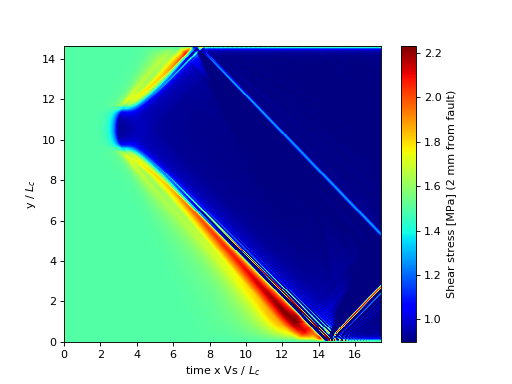

In [40]:
f3=plt.figure(3)
ax31=f3.add_subplot(111)
im=ax31.pcolor(tt*vs/(size_patch),(0.3-xt)/(size_patch),map_sim/1e6,cmap='jet',vmin=(tau_f-0.2)*1e-6, vmax=tau_p*1e-6)#,vmin=(tau_f-0.2)/1000000, vmax=tau_p/1000000)
# plt.gca().invert_yaxis()
cbar3=plt.colorbar(im)#, cax=cax)#,fraction=0.046, pad=0.04)
cbar3.ax.set_ylabel('Shear stress [MPa] (2 mm from fault)')
ax31.set_ylabel('y / $L_c$')
ax31.set_xlabel('time x Vs / $L_c$')
# for i,n in enumerate(sg_pos):
#     ax31.axhline(n,linestyle='dotted',color='r')
#     ax31.annotate('sg '+str(i+1), (0.4,sg_pos[i]+0.01))

<IPython.core.display.Javascript object>


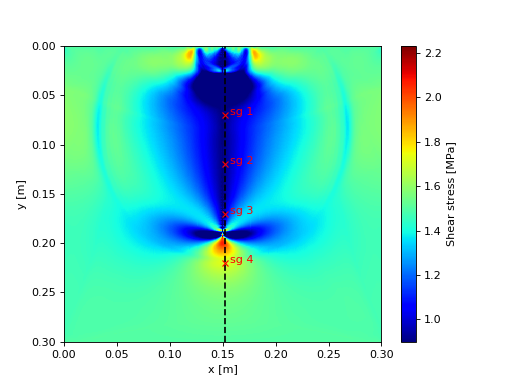

In [49]:
f4=plt.figure(4)
ax41=f4.add_subplot(111)
im4=ax41.pcolor(FL-zz,xx,screenshot*1e-6,cmap='jet',vmin=(tau_f-0.2)*1e-6, vmax=tau_p*1e-6)
plt.gca().invert_yaxis()
cbar4=plt.colorbar(im4)#, cax=cax)#,fraction=0.046, pad=0.04)
cbar4.ax.set_ylabel('Shear stress [MPa]')
ax41.set_ylabel('y [m]')
ax41.set_xlabel('x [m]')
ax41.axvline(sg_pos_z,linestyle='dashed',color='k')
for i,posz in enumerate(sg_pos):
    ax41.plot(sg_pos_z,posz,'xr')
    ax41.annotate('sg '+ str(i+1), (sg_pos_z+0.005,posz),color='r')


In [50]:
f4.savefig('shear_sgpos.png')

In [41]:
f3.savefig('adimplot.png')